# Total-Variation based Bayesian Image Deblurring

In this notebook, we will perform image deblurring via a Bayesian *Maximum a Posteriori* (MAP) approach. Our image prior will be composed of a total variation (TV) term and a positivity constraint. 

The forward model defining the blurring process is defined as:

$$\mathbf{y}=\mathbf{H}\mathbf{x}+\mathbf{n}$$

where:
- $\mathbf{y} \in \mathbb{R}^{d}$ is the observed blurred and noisy image,
- $\mathbf{H}: \mathbb{R}^{d\times d}$ is the blurring operator, which consists on a convolution with a Gaussian point-spread-function (PSF),
- $\mathbf{x} \in \mathbb{R}^{d}$ is the original clean image we want to recover,
- $\mathbf{n} \in \mathbb{R}^{d}$ is independent and identically distributed Gaussian noise.

In [1]:
# Importing necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import skimage
from pyxu.operator import Convolve, L21Norm, Gradient, SquaredL2Norm, PositiveOrthant
from pyxu.opt.solver import PD3O
from pyxu.opt.stop import RelError, MaxIter

# Setting up GPU support
GPU = False
if GPU:
    import cupy as xp
else:
    import numpy as xp

## Loading and Preprocessing the Image

We will use a sample image from the `skimage.data` module and preprocess it to be suitable for the deblurring process. The image is converted to a float type and normalized to have pixel values between 0 and 1.

In [ ]:
!pip install scikit-image

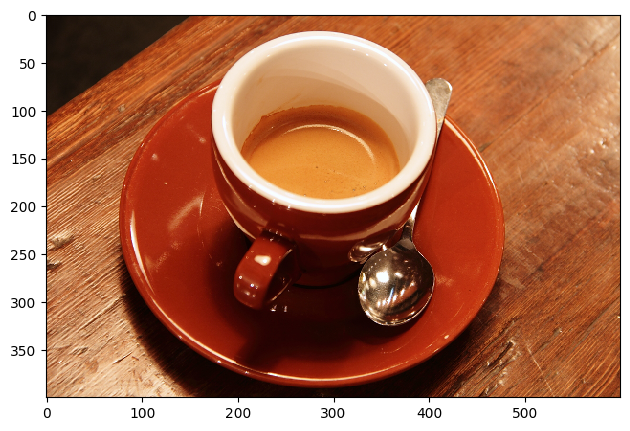

In [3]:
# Loading and preprocessing the image
data = skimage.data.coffee()
skimage.io.imshow(data)
data = xp.asarray(data.astype("float32") / 255.0).transpose(2, 0, 1)

## Creating the Blurring Kernel

We will create a Gaussian blurring kernel (a.k.a. point spread function or PSF) to simulate the blurring effect of the camera lens on the image. The kernel is defined by its standard deviation and width. The Gaussian function is given by:
$$ G(x)=\frac{1}{2\pi\sigma^{2}} e^{−\frac{(x−\mu)^{2}}{2\sigma^{2}}} $$

where:
- $G(x)$ is the Gaussian function,
- $\sigma$ is the standard deviation,
- $\mu$ is the mean.

In [4]:
# Creating the Gaussian blurring kernel
sigma = 7
width = 13
mu = (width - 1) / 2
gauss = lambda x: (1 / (2 * np.pi * sigma**2)) * np.exp(
    -0.5 * ((x - mu) ** 2) / (sigma**2)
)

kernel_1d = np.fromfunction(gauss, (width,)).reshape(1, -1)
kernel_1d /= kernel_1d.sum()

kernel_1d = xp.asarray(kernel_1d)

## Applying the Blurring and Adding Noise

We will use the created Gaussian kernel to blur the image and then add Gaussian noise to simulate a real-world scenario where camera sensors are corrupted by thermal noise. Note that the 2D Gaussian kernel is defined in a separable fashion for efficiency reasons. 

/home/joan/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


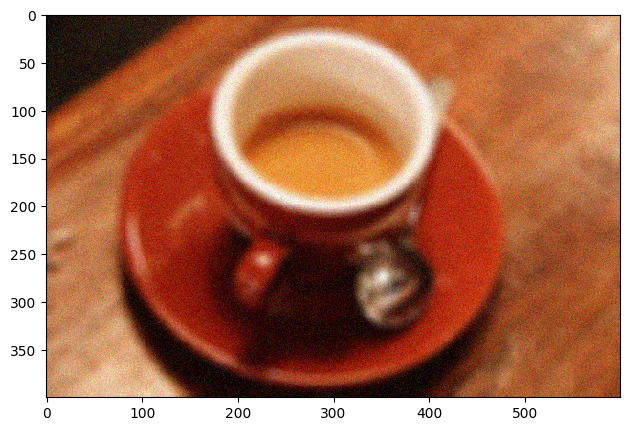

In [5]:
# Applying the blurring and adding noise
conv = Convolve(
    arg_shape=data.shape,
    kernel=[xp.array([1]), kernel_1d, kernel_1d], 
    center=[0, width // 2, width // 2],
    mode="reflect",
    enable_warnings=True,
)
y = conv(data.ravel()).reshape(data.shape)
y = xp.random.normal(loc=y, scale=0.05)
y = y.clip(0, 1)
skimage.io.imshow(y.transpose(1,2,0))

## MAP Estimate with Composite Positivity + Total Variation Prior 

Maximum a Posteriori seeks the most credible output given the likelihood and image prior, that is a mode of posterior distribution (not necessarily unique, but globally optimal in the log-concave case). The likelihood model is based on the noise distribution (here assumed Gaussian), and the prior model incorporates our assumptions about the image. The total variation prior promotes "mostly flat" solutions, helping to preserve edges while smoothing out noise. The positivity constraint ensures that the pixel values of the deblurred image remain non-negative.

The MAP optimization problem can be written as:
$$\hat{\mathbf{x}}=\arg\min_{\mathbf{x} ≥0} \frac{1}{2}\Vert \mathbf{y}− \mathbf{H}\mathbf{x}\Vert^{2}_{2}+\lambda\Vert\nabla\mathbf{x}\Vert_{1,2}$$

where:

- $\Vert\mathbf{y}−\mathbf{H}\mathbf{x}\Vert_2^2$ is the squared $L_2$-norm representing the data fidelity term (likelihood),
- $\Vert \nabla \mathbf{x}\Vert_{2, 1}=\sqrt{\Vert \nabla_{x} \mathbf{x} \Vert_{1}^{2} + \Vert \nabla_{y} \mathbf{x}\Vert_{1}^{2}}$ is the isotropic total variation norm,
- $\lambda$ is the regularization parameter,
- $\mathbf{x}≥0$ is the positivity constraint.

We solve this problem with the PD3O solver [🔗](../api/opt.solver.html#pyxu.opt.solver.PD3O), with 
- $\mathcal{F}(\mathbf{x})=\frac{1}{2}\Vert \mathbf{y}− \mathbf{H}\mathbf{x}\Vert^{2}_{2}$,
- $\mathcal{G}(\mathbf{x})=\iota_+(\mathbf{x})$,
- $\mathcal{H}(\mathbf{z})=\lambda \Vert \mathbf{z}\Vert_{2, 1}$,
- $\mathcal{K}=\nabla$.

PD3O manages the composite, non-smooth, and non-proximable term $\mathcal{H}(\mathcal{K} \mathbf{x})$ utilizing its Fenchel biconjugate. This implies that, while the minimization of the functionals $\mathcal{F}$ and $\mathcal{G}$ occurs on the primal variable of interest, the minimization of the term $\mathcal{H}(\mathcal{K} \mathbf{x})$ is indirectly undertaken on the dual variable, and, upon convergence, subsequently on the primal when the primal-dual gap reduces to zero. Therefore, it is crucial to set the relative improvement convergence threshold of PD3O at a significantly low level to ensure the proper convergence of the algorithm; if not, the resulting solution will not exhibit the mostly flat behavior expected from the application of a Total Variation (TV) prior. A challenge to note is that PD3O, being generically designed, may demonstrate slow convergence when seeking such high accuracies.

In [6]:
# Setting up the MAP approach with total variation prior and positivity constraint
sl2 = SquaredL2Norm(dim=y.size).asloss(y.ravel())
loss = sl2 * conv

l21 = L21Norm(arg_shape=(2, *y.shape), l2_axis=(0, 1))

grad = Gradient(
    arg_shape=y.shape,
    directions=(1, 2),
    gpu=GPU,
    diff_method="fd",
    scheme="central",
    accuracy=3,
)

stop_crit = RelError(
            eps=1e-6,
            var="x",
            f=None,
            norm=2,
            satisfy_all=True,
        ) | MaxIter(5000)

positivity = PositiveOrthant(dim=y.size)
solver = PD3O(f=loss, g=positivity, h= 3e-2 * l21, K=grad, verbosity=500)
solver.fit(x0=y.ravel(), stop_crit=stop_crit)

# Getting the deblurred image
recons = solver.solution().reshape(y.shape)
recons /= recons.max()


INFO -- [2023-10-17 07:05:35.239986] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO -- [2023-10-17 07:06:08.411195] Iteration 500
	iteration: 500
	RelError[x]: 4.904123121813688e-05
	N_iter: 501.0
INFO -- [2023-10-17 07:06:43.122985] Iteration 1_000
	iteration: 1000
	RelError[x]: 2.2254227486883125e-05
	N_iter: 1001.0
INFO -- [2023-10-17 07:07:18.052272] Iteration 1_500
	iteration: 1500
	RelError[x]: 1.2434739751099225e-05
	N_iter: 1501.0
INFO -- [2023-10-17 07:07:53.556897] Iteration 2_000
	iteration: 2000
	RelError[x]: 7.486998979265033e-06
	N_iter: 2001.0
INFO -- [2023-10-17 07:08:28.714765] Iteration 2_500
	iteration: 2500
	RelError[x]: 4.698671387686982e-06
	N_iter: 2501.0
INFO -- [2023-10-17 07:09:05.089385] Iteration 3_000
	iteration: 3000
	RelError[x]: 3.0566844199002705e-06
	N_iter: 3001.0
INFO -- [2023-10-17 07:09:43.665496] Iteration 3_500
	iteration: 3500
	RelError[x]: 2.079001212186548e-06
	N_iter: 3501.0
INFO -- [2023-10-17 07:10:22.235798] Iteration 4_000


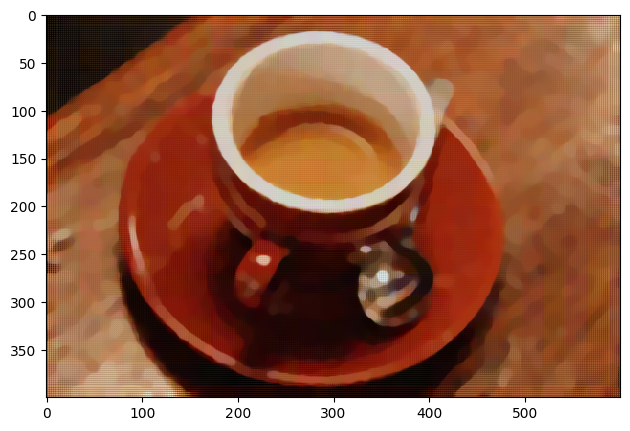

In [9]:
skimage.io.imshow(recons.transpose(1,2,0))

In [10]:
# Evaluating the deblurred image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

if GPU:
    data = data.get()
    y = y.get()
    recons = recons.get()

data = data.transpose(1, 2, 0)
y = y.transpose(1, 2, 0)
recons = recons.clip(0,1)
recons = recons.transpose(1, 2, 0)

mse_y = mse(data, y)
ssim_y = ssim(data, y, channel_axis=2, data_range=1.)
psnr_y = psnr(data, y, data_range=1.)
mse_recons = mse(data, recons)
ssim_recons = ssim(data, recons, channel_axis=2, data_range=1.)
psnr_recons = psnr(data, recons, data_range=1.)


## Visualizing the Results

Finally, let's visualize the original image, the blurred and noisy image, and the deblurred image obtained using the MAP approach with a total variation prior and positivity constraint. We will also display the evaluation metrics for a comprehensive comparison.

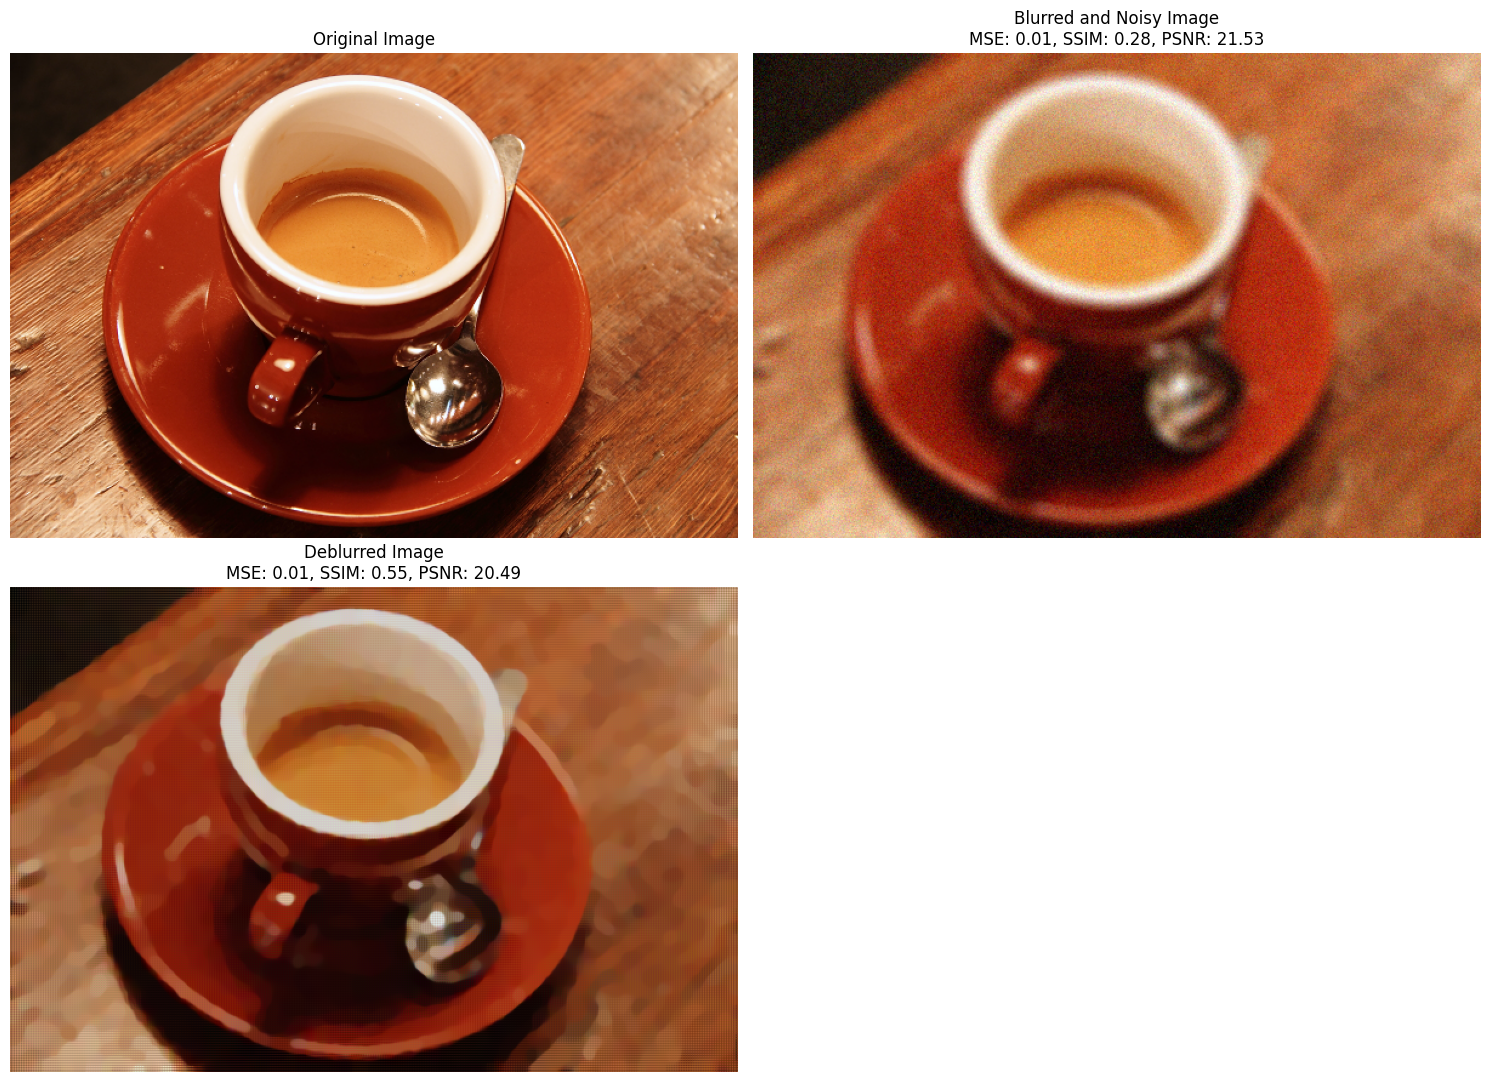

In [11]:
# Visualizing the results

plt.figure(figsize=(15, 11))

plt.subplot(2,2,1)
plt.imshow(data.clip(0,1))
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(y.clip(0, 1))
plt.title(f"Blurred and Noisy Image\nMSE: {mse_y:.2f}, SSIM: {ssim_y:.2f}, PSNR: {psnr_y:.2f}")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(recons)
plt.title(f"Deblurred Image\nMSE: {mse_recons:.2f}, SSIM: {ssim_recons:.2f}, PSNR: {psnr_recons:.2f}")
plt.axis('off')

plt.tight_layout()
plt.show()
